In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/IS/assignment/data/data.npy" "data.npy"

In [3]:
!cp "/content/drive/MyDrive/IS/assignment/data/label.npy" "label.npy"

In [4]:
!cp "/content/drive/MyDrive/IS/assignment/data/driver_imgs_list.csv" "./driver_imgs_list.csv"

In [5]:
!cp "/content/drive/MyDrive/IS/assignment/data/model/IS.h5" "IS.h5"

In [6]:
!cp "/content/drive/MyDrive/IS/assignment/data/model/classificationRBF_model.sav" "classificationRBF_model.sav"

In [7]:
!cp "/content/drive/MyDrive/IS/assignment/data/model/classification_model.sav" "classificationPoly_model.sav"

In [8]:
!pip install "dask[bag]"
!pip install "dask[complete]"

     |████████████████████████████████| 92kB 6.5MB/s 
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=e98089c2a7c1d93ccc8dd0ca7d3aa7b627451703d4dc2cc5806da421bffcf782
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built locket
     |████████████████████████████████| 665kB 7.7MB/s 
     |████████████████████████████████| 102kB 8.5MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=15941ba0e85788d3da6b95efbe879e1b900dc75fc6d38cab3f94bc1c1c4aa150
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
Successfully built contextvars
ERROR: distributed 2.30.1 has requirement cloudpickle>=1.5.0, but you'll have cloudpickle 1.3.0 which is incompatible.
  Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distributed-1.25.3


In [9]:
from google.colab import drive
import os 
import random
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag
from dask import threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.svm import SVC
from sklearn import datasets, svm, metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



import keras
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers import Flatten,Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from keras.layers.normalization import BatchNormalization
from keras import optimizers

In [10]:
driver_details = pd.read_csv('./driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [11]:
train_image = np.load("data.npy",allow_pickle=True)
image_label = np.load("label.npy",allow_pickle=True)

In [12]:
## Randomly shuffling the images

import random
random.shuffle(train_image)

In [13]:
driv_selected = ['p050', 'p015', 'p022', 'p056']


# Prepare trainset, testset



In [14]:
## Splitting the train and test

X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

for features,labels,drivers in train_image:
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)
    
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18831 3593
18831 3593


In [15]:
## Converting images to nparray. Encoding the Y

X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


print (X_train.shape)


(18831, 224, 224, 3)


# VGG16 model

In [ ]:
## Defining the input

from keras.layers import Input
vgg16_input = Input(shape = (224, 224, 3), name = 'Image_input')


## The VGG model

from keras.applications.vgg16 import VGG16, preprocess_input

#Get back the convolutional part of a VGG network trained on ImageNet
model_vgg16_conv = VGG16(weights='imagenet', include_top=False, input_tensor = vgg16_input)
model_vgg16_conv.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
#Use the generated model 
from keras.models import Model


output_vgg16_conv = model_vgg16_conv(vgg16_input)


x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(10, activation='softmax', name='predictions')(x)

vgg16_pretrained = Model(vgg16_input, x)
vgg16_pretrained.summary()

# Compile CNN model
sgd = optimizers.SGD(lr = 0.001)
vgg16_pretrained.compile(loss='categorical_crossentropy',optimizer = sgd,metrics=['accuracy'])


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
predictions (Dense)          (None, 10)                250890    
Total params: 14,965,578
Trainable params: 14,965,578
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

checkpointer = ModelCheckpoint('vgg_weights_aug_setval_sgd.hdf5', verbose=1, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)


datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )
#datagen.fit(X_train)
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

# Fits the model on batches with real-time data augmentation:
vgg16_model = vgg16_pretrained.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 25, verbose = 1, validation_data = (X_test, y_test))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
293/292 [==============================] - ETA: 0s - loss: 1.9591 - accuracy: 0.3412
Epoch 00001: val_loss improved from inf to 1.87634, saving model to vgg_weights_aug_setval_sgd.hdf5
293/292 [==============================] - 225s 767ms/step - loss: 1.9591 - accuracy: 0.3412 - val_loss: 1.8763 - val_accuracy: 0.3434
Epoch 2/25
293/292 [==============================] - ETA: 0s - loss: 1.7754 - accuracy: 0.3741
Epoch 00002: val_loss improved from 1.87634 to 1.56786, saving model to vgg_weights_aug_setval_sgd.hdf5
293/292 [==============================] - 221s 754ms/step - loss: 1.7754 - accuracy: 0.3741 - val_loss: 1.5679 - val_accuracy: 0.4625
Epoch 3/25
293/292 [==============================] - ETA: 0s - loss: 1.5573 - accuracy: 0.4559
Epoch 00003: val_loss improved from 1.56786 to 1.18818, saving model to vgg_weights_aug_setval_sgd.hdf5
293/292 [==============================] - 220s 752ms/step

In [ ]:
vgg16_pretrained.save("IS.h5")
!cp "IS.h5" "/content/drive/MyDrive/IS/assignment/data/IS.h5" 

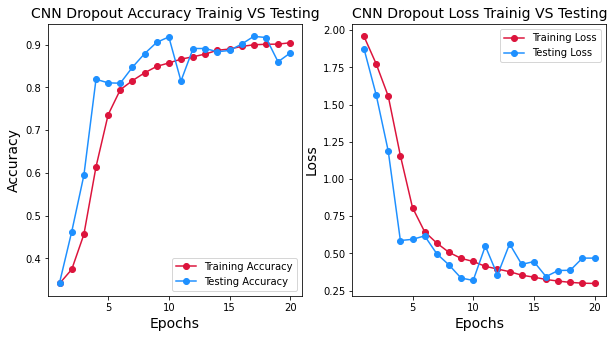

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(vgg16_pretrained.history.history['accuracy']) + 1), vgg16_pretrained.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(vgg16_pretrained.history.history['val_accuracy']) + 1), vgg16_pretrained.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['loss']) + 1), vgg16_pretrained.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(vgg16_pretrained.history.history['val_loss']) + 1), vgg16_pretrained.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')

# Create feature extraction model

In [16]:
def create_model(path):
  return keras.models.load_model(path)

In [17]:
SMmodel = create_model("IS.h5")
SMmodel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
predictions (Dense)          (None, 10)                250890    
Total params: 14,965,578
Trainable params: 14,965,578
Non-trainable params: 0
_________________________________________________________________


In [18]:
def create_embedding_model(model):
  return keras.Model(inputs=model.input,outputs=model.layers[-2].output)

In [19]:
SMembeddingmodel = create_embedding_model(SMmodel)
SMembeddingmodel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_input (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [20]:
print (X_train.shape, y_train.shape)

(18831, 224, 224, 3) (18831, 10)


In [21]:
features = SMembeddingmodel.predict(X_train)

In [22]:
features.shape

(18831, 25088)

In [23]:
y_train.shape
y_svc = [np.argmax(ele) for ele in y_train]
y_svc = np.array(y_svc)
y_svc.shape

(18831,)

# Train SVM poly

In [ ]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma='scale',kernel='poly',max_iter=100, verbose=1)

In [ ]:
#fit to the trainin data
classifier.fit(features,y_svc)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=100, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=1)

Save SVM Poly model

In [ ]:
filename = 'classificationRBF_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

# Train SVM RBF

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(features, y_svc)

In [ ]:
import pickle

Save SVM RBF model

In [ ]:
filename = 'classificationRBF_model.sav'
pickle.dump(classifier, open(filename, 'wb'))

# Load SVM Poly model

In [ ]:
PolySVM_model = pickle.load(open("classificationPoly_model.sav", 'rb'))

In [ ]:
print(X_test.shape, y_test.shape)

(3663, 224, 224, 3) (3663, 10)


preprocess to predict

In [ ]:
y_testsvmpoly = [np.argmax(ele) for ele in y_test]
y_testsvmpoly = np.array(y_testsvmpoly)
y_testsvmpoly.shape

(3663,)

Extract features

In [ ]:
polyfeatures = SMembeddingmodel.predict(X_test)
polyfeatures.shape 

(3663, 25088)

Predict

In [ ]:
y_predsvmpoly = PolySVM_model.predict(polyfeatures)
y_predsvmpoly.shape

(3663,)

Metric

In [ ]:
print("Classification report for classifier %s:\n%s\n"
      % (PolySVM_model, metrics.classification_report(y_testsvmpoly, y_predsvmpoly)))

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=100, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=1):
              precision    recall  f1-score   support

           0       0.96      0.22      0.35      1303
           1       1.00      0.93      0.97       625
           2       1.00      0.67      0.80       492
           3       1.00      0.93      0.97       383
           4       0.99      0.52      0.69       329
           5       0.41      0.59      0.48       217
           6       0.96      0.42      0.58       157
           7       0.26      0.88      0.40        92
           8       0.03      0.69      0.05        49
           9       0.00      0.00      0.00        16

    accuracy                           0.56      3663
   macro avg       0.66      0.59      0.53      3663
weighted a

Confusion matrix

In [ ]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_testsvmpoly, y_predsvmpoly))

Confusion matrix:
[[281   0   0   0   0 167   0 184 671   0]
 [  6 584   0   0   0  16   0   0  19   0]
 [  0   0 331   0   1   0   0   0 160   0]
 [  0   0   0 358   0   0   0   0  25   0]
 [  0   0   0   0 172   0   0   1 156   0]
 [  0   0   0   0   0 128   0  26  63   0]
 [  0   0   0   0   0   0  66   5  86   0]
 [  0   0   0   0   0   0   0  81  11   0]
 [  0   1   0   0   0   0   3  11  34   0]
 [  5   0   0   0   0   1   0   1   9   0]]


Score

In [ ]:
PolySVM_model.score(polyfeatures,y_testsvmpoly)

0.5555555555555556

# Load SVM RBF model

In [ ]:
RBFSVM_model = pickle.load(open("classificationRBF_model.sav", 'rb'))

In [ ]:
print (X_test.shape, y_test.shape)

(3663, 224, 224, 3) (3663, 10)


preprocess to predict

In [ ]:
y_testsvmRBF = [np.argmax(ele) for ele in y_test]
y_testsvmRBF = np.array(y_testsvmRBF)
y_testsvmRBF.shape

(3663,)

Extract features

In [ ]:
rbffeatures = SMembeddingmodel.predict(X_test)

Predict



In [ ]:
y_predsvmRBF = RBFSVM_model.predict(rbffeatures)
y_predsvmRBF.shape

(3663,)

Metric

In [ ]:
print("Classification report for classifier %s:\n%s\n"
      % (RBFSVM_model, metrics.classification_report(y_testsvmRBF, y_predsvmRBF)))

Classification report for classifier SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=100, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=1):
              precision    recall  f1-score   support

           0       0.96      0.22      0.35      1303
           1       1.00      0.93      0.97       625
           2       1.00      0.67      0.80       492
           3       1.00      0.93      0.97       383
           4       0.99      0.52      0.69       329
           5       0.41      0.59      0.48       217
           6       0.96      0.42      0.58       157
           7       0.26      0.88      0.40        92
           8       0.03      0.69      0.05        49
           9       0.00      0.00      0.00        16

    accuracy                           0.56      3663
   macro avg       0.66      0.59      0.53      3663
weighted a

Confusion matrix

In [ ]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_testsvmRBF, y_predsvmRBF))

Confusion matrix:
[[281   0   0   0   0 167   0 184 671   0]
 [  6 584   0   0   0  16   0   0  19   0]
 [  0   0 331   0   1   0   0   0 160   0]
 [  0   0   0 358   0   0   0   0  25   0]
 [  0   0   0   0 172   0   0   1 156   0]
 [  0   0   0   0   0 128   0  26  63   0]
 [  0   0   0   0   0   0  66   5  86   0]
 [  0   0   0   0   0   0   0  81  11   0]
 [  0   1   0   0   0   0   3  11  34   0]
 [  5   0   0   0   0   1   0   1   9   0]]


Score

In [ ]:
RBFSVM_model.score(rbffeatures,y_testsvmRBF)

0.5555555555555556

# Load VGG16+softmax model

In [ ]:
y_predsoftmax = testmodel.predict(X_test)

In [ ]:
y_predsm = [np.argmax(ele) for ele in y_predsoftmax]
y_predsm = np.array(y_predsm)
y_predsm.shape

(3617,)

In [ ]:
y_testsm = [np.argmax(ele) for ele in y_test]
y_testsm = np.array(y_testsm)
y_testsm.shape

(3617,)

In [ ]:
print("Classification report for classifier %s:\n%s\n"
      % (testmodel, metrics.classification_report(y_testsm, y_predsm)))

Classification report for classifier <tensorflow.python.keras.engine.functional.Functional object at 0x7f4f664e8fd0>:
              precision    recall  f1-score   support

           0       0.95      0.88      0.92      1355
           1       1.00      0.98      0.99       611
           2       0.98      0.94      0.96       473
           3       0.98      0.99      0.99       405
           4       0.88      0.59      0.70       249
           5       0.50      1.00      0.67       226
           6       0.92      0.83      0.87       147
           7       0.83      0.81      0.82        83
           8       0.28      0.27      0.28        56
           9       0.00      0.00      0.00        12

    accuracy                           0.89      3617
   macro avg       0.73      0.73      0.72      3617
weighted avg       0.91      0.89      0.89      3617




In [ ]:
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_testsm, y_predsm))

Confusion matrix:
[[1197    0    0    0   16  142    0    0    0    0]
 [   0  597    0    0    0    0    3    0    0   11]
 [   0    0  444    0    3    0    1    0   25    0]
 [   3    0    0  401    1    0    0    0    0    0]
 [  46    0    0    0  146   57    0    0    0    0]
 [   0    0    0    0    0  226    0    0    0    0]
 [   0    0    0    8    0    4  122    0   13    0]
 [   0    0    0    0    0   16    0   67    0    0]
 [   4    2    8    0    0    6    7   14   15    0]
 [  10    0    0    0    0    2    0    0    0    0]]


In [ ]:
 tags = { "C0": "safe driving",
"C1": "texting - right",
"C2": "talking on the phone - right",
"C3": "texting - left",
"C4": "talking on the phone - left",
"C5": "operating the radio",
"C6": "drinking",
"C7": "reaching behind",
"C8": "hair and makeup",
"C9": "talking to passenger" }

Image number: 0
Image number: 1
Image number: 2
Image number: 3
Image number: 4
Image number: 5
Image number: 6
Image number: 7
Image number: 8
Image number: 9
Image number: 10
Image number: 11
Image number: 12
Image number: 13
Image number: 14
Image number: 15
Image number: 16
Image number: 17
Image number: 18
Image number: 19


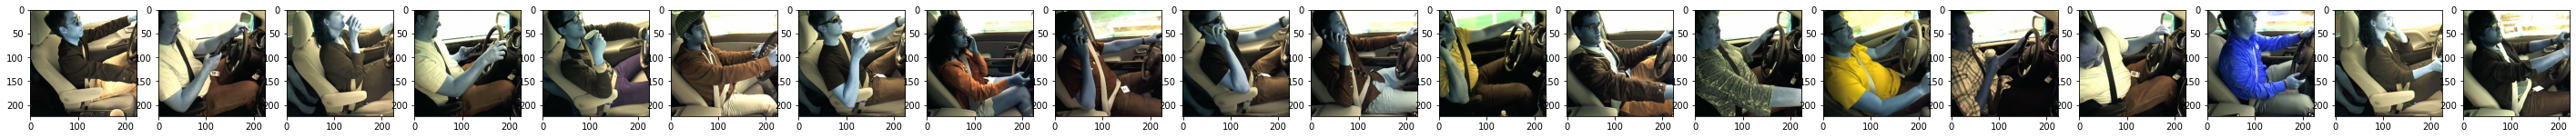

In [ ]:
# labels is the image array
test_image = []
i = 0
fig, ax = plt.subplots(1, 20, figsize = (50,50 ))

files = os.listdir('./drive/MyDrive/IS/assignment/data/imgs/test')
nums = np.random.randint(low=1, high=len(files), size=20)
for i in range(20):
    print ('Image number:',i)
    imgpath = os.path.join('./drive/MyDrive/IS/assignment/data/imgs/test',files[nums[i]])
    img = cv2.imread(imgpath)
    #img = color.rgb2gray(img)
    img = img[50:,120:-50]
    img = cv2.resize(img,(224,224))
    test_image.append(img)
    ax[i].imshow(img,cmap = 'gray')
    plt.show

In [ ]:
test = []

for img in test_image:
    test.append(img)
    
#vgg16_pretrained.load_weights('vgg_weights_aug_setval_sgd.hdf5')


test = np.array(test).reshape(-1,224,224,3)
#prediction = vgg16_pretrained.predict(test)
prediction = testmodel.predict(test)

In [ ]:
prediction[0]

array([2.6467970e-09, 5.9027886e-01, 5.9059633e-09, 1.4905255e-07,
       1.0428150e-08, 2.5560937e-04, 4.0852618e-01, 6.9031449e-07,
       2.9242903e-04, 6.4604025e-04], dtype=float32)

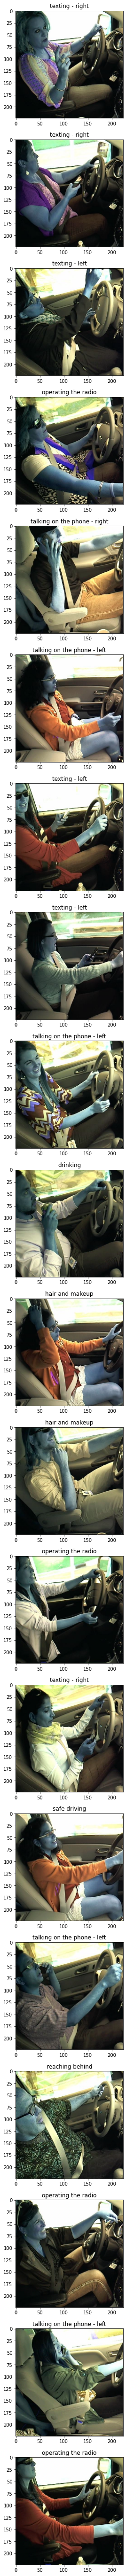

In [ ]:
# labels is the image array
i = 0
fig, ax = plt.subplots(20, 1, figsize = (100,100))

for i in range(20):
    ax[i].imshow(test[i].squeeze())
    predicted_class = 'C'+str(np.where(prediction[i] == np.amax(prediction[i]))[0][0])
    ax[i].set_title(tags[predicted_class])
    plt.show
    